In [1]:
import glob
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas
import scipy.stats
from lenstronomy.Data.coord_transforms import Coordinates
from photutils.segmentation import detect_sources
from scipy.optimize import minimize
from dolphin.processor.config import ModelConfig

# Create lens light subtracted image data

In [2]:
from dolphin.analysis.output import Output
output = Output('../2_dolphin_modelling/')

-0.79466809872013 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  0.7946680987201334


/Users/chinyi/anaconda3/envs/astroconda/lib/python3.6/site-packages/lenstronomy/Plots/model_band_plot.py:63: RuntimeWarning: divide by zero encountered in log10
  log_model = np.log10(model)
/Users/chinyi/anaconda3/envs/astroconda/lib/python3.6/site-packages/lenstronomy/Plots/model_band_plot.py:63: RuntimeWarning: invalid value encountered in log10
  log_model = np.log10(model)
/Users/chinyi/anaconda3/envs/astroconda/lib/python3.6/site-packages/lenstronomy/Plots/plot_util.py:367: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("cubehelix"))
  cmap_new.set_bad(color="k", alpha=1.0)
/Users/chinyi/anaconda3/envs/astroconda/lib/python3.6/site-packages/lenstronomy/Plots/plot_util.py:368: MatplotlibDeprecationWarning: You are modifying the state of a globally register

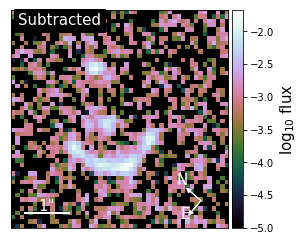

In [3]:
lens = 'SL2SJ1359+5535'
v_band_index, v_band = 0, 'F606W'
df = output.get_kwargs_data_joint(lens)['multi_band_list']
df_sel = df[v_band_index]
image_array, back_rms = output.get_subtracted_image(lens_name=lens,model_id="dinos_i", band_index=v_band_index)
df_sel[0]['lens_light_subtracted_image_data'] = image_array
df_sel.append({})

config = ModelConfig("../2_dolphin_modelling//settings/{}_config.yml".format(lens))
df_sel[3]['mask'] = (config.get_masks()[v_band_index])
df_sel[3]['band'] = output.load_output(lens,'dinos_i')['settings']['band']
df_sel[3]['kwargs_result'] = output.load_output(lens,'dinos_i')['kwargs_result']

#np.save('h5_/image_{}_{}.'.format(lens, v_band),df_sel)



# load the output files

In [4]:
files_all_dinos = sorted(glob.glob("pkl_files/*.npy"))
names_all_dinos = [x[16:30] for x in files_all_dinos]

df_table = pandas.read_csv("Data/lit_gamma.csv")
slacs_mask = np.in1d(names_all_dinos, df_table[df_table['compare']==True]['Lens Name'])


files = np.array(files_all_dinos)[slacs_mask]


In [5]:
def get_signal_to_noises(a=1, b=1, files=files, verbose=False):
    """
    Compute signal to noise ratios for all images.
    :param a: weight for radial distance
    :type a: float
    :param b: weight for angular stretch
    :type b: float
    :param files: list of files
    :type files: list
    :param verbose: for plotting
    :type verbose: bool
    :return: names, weighted_sns, unweighted_sns
    :rtype: np.array, np.array, np.array
    """
    names = []
    weighted_sns = []
    unweighted_sns = []

    for i, file in enumerate(files):
        with open(file, "rb") as f:
            data = np.load(f, allow_pickle=True)

            kwargs_data = data[0]
            image = kwargs_data["image_data"]
            background_rms = kwargs_data["background_rms"]
            lens_light_subtracted_image = data[0]["lens_light_subtracted_image_data"]
            noise = image.copy()
            noise[noise < 0.0] = 1e-10
            noise = np.sqrt(
                noise / kwargs_data["exposure_time"]
                + kwargs_data["background_rms"] ** 2
            )

            kwargs_result = data[3]["kwargs_result"]
            mask = data[3]["mask"]

            theta_E = kwargs_result["kwargs_lens"][0]["theta_E"]

            ra_at_xy_0 = kwargs_data["ra_at_xy_0"]
            dec_at_xy_0 = kwargs_data["dec_at_xy_0"]

            ra_offset = kwargs_data["ra_shift"]
            dec_offset = kwargs_data["dec_shift"]

            transform_pix2angle = kwargs_data["transform_pix2angle"]
            coords = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)

            center_x = kwargs_result["kwargs_lens"][0]["center_x"] - ra_offset
            center_y = kwargs_result["kwargs_lens"][0]["center_y"] - dec_offset

            x0, y0 = coords.map_coord2pix(center_x, center_y)

            xs, ys = np.meshgrid(np.arange(image.shape[0]), np.arange(image.shape[1]))

            x_coords, y_coords = coords.map_pix2coord(xs.flatten(), ys.flatten())
            x_coords = x_coords.reshape(xs.shape)
            y_coords = y_coords.reshape(ys.shape)

            r = np.sqrt((x_coords - center_x) ** 2 + (y_coords - center_y) ** 2)

            radial_weight = np.abs(r - theta_E) / theta_E

            threshold = 3.0
            sn_masked = np.abs(lens_light_subtracted_image / noise)
            sn_masked[lens_light_subtracted_image < threshold * background_rms] = 0.0
            sn_masked *= mask

            max_pixel = np.argwhere(sn_masked == sn_masked.max())[0]
            max_ra, max_dec = coords.map_pix2coord(max_pixel[1], max_pixel[0])
            max_ra -= center_x
            max_dec -= center_y
            delta_pa = np.arctan((y_coords - center_y) / (x_coords - center_x))

            delta_pa -= np.arctan(max_dec / max_ra)
            delta_pa = delta_pa % (np.pi)
            delta_pa[delta_pa > np.pi / 2] = np.pi - delta_pa[delta_pa > np.pi / 2]

            angular_weight = delta_pa * 2.0 / np.pi

            weight = 1.0 + a * radial_weight * (1.0 + b * angular_weight)

            weighted_signal = lens_light_subtracted_image * weight
            weighted_signal[
                lens_light_subtracted_image < threshold * background_rms
            ] = 0.0
            weighted_signal *= mask

            segmentation_mask = detect_sources(
                weighted_signal / noise, 0, npixels=5
            ).data
            segmentation_mask[segmentation_mask > 0] = 1.0
            weighted_signal *= segmentation_mask

            weighted_sn = weighted_signal / noise

            final_mask = np.zeros_like(weighted_signal)
            final_mask[weighted_signal > 0.0] = 1.0

            names.append(file[16:30])
            weighted_sns.append(
                np.sum(weighted_signal) / np.sqrt(np.sum(noise**2 * final_mask))
            )
            unweighted_sns.append(
                np.sum(lens_light_subtracted_image * final_mask)
                / np.sqrt(np.sum(noise**2 * final_mask))
            )

            if verbose and i == 1:
                plt.matshow(
                    weighted_sn,
                    origin="lower",
                )
                plt.plot(x0, y0, "rx")
                plt.title(f"{names[-1][4:9]}, total wtd S/N: {weighted_sns[-1]:.1f}")
                plt.colorbar(label="weighted S/N")
                plt.show()

    return np.array(names), np.array(weighted_sns), np.array(unweighted_sns)

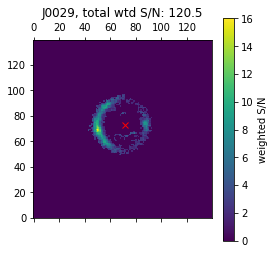

In [6]:
# example
(
    names_all_dinos,
    weighted_sns_all_dinos,
    unweighted_sns_all_dinos,
) = get_signal_to_noises(a=1, b=1, files=files_all_dinos, verbose=True)

# correlation between S/N and gamma_err

In [7]:
def get_pearson_r(params):
    """

    :param a:
    :type a:
    :param b:
    :type b:
    :return:
    :rtype:
    """
    a, b = params
    _, weighted_sns, unweighted_sns = get_signal_to_noises(
        a, b, files=files_all_dinos, verbose=False
    )

    return scipy.stats.pearsonr(np.log(weighted_sns), np.log(gamma_errs_all_dinos))[0]

In [8]:
df_all = pandas.read_csv("Data/lit_gamma.csv")[:77]
names_all_dinos = [x[16:30] for x in files_all_dinos]

gammas_all_dinos = []
gamma_errs_all_dinos = []

for name in names_all_dinos:
    gammas_all_dinos.append(df_all[df_all["Lens Name"] == name]["γ"].values[0])
    gamma_errs_all_dinos.append(df_all[df_all["Lens Name"] == name]["γ err"].values[0])


res = minimize(
    get_pearson_r,
    x0=np.array([1.0, 1]),
    bounds=[(-100, 100), (-100, 100)],
    # method="Nelder-Mead"
)

res, get_pearson_r(res.x)

(      fun: -0.7060153032948666
  hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
       jac: array([-4.29656275e-06, -6.55031585e-06])
   message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
      nfev: 39
       nit: 12
      njev: 13
    status: 0
   success: True
         x: array([15.55382542,  0.07077   ]),
 -0.7060153032948666)

Taking a = 15, b = 0.

## loading values from other lens outputs for comparison

In [9]:
# recompute weighted SNs with optimized weights
(
    names_all_dinos,
    weighted_sns_all_dinos,
    unweighted_sns_all_dinos,
) = get_signal_to_noises(a=15, b=0, files=files_all_dinos, verbose=False)

In [10]:
names, weighted_sns, unweighted_sns = get_signal_to_noises(a=15, b=0, verbose=False)

In [11]:
df = pandas.read_csv("Data/lit_gamma.csv")
df = df[df['compare']==True]

In [12]:
# match lens_name and extract gamma
gammas_tan = []
gamma_errs_tan = []
gammas_eth = []
gamma_errs_eth = []

for name in names:
    gammas_tan.append(df[df["Lens Name"] == name]["γ"].values[0])
    gamma_errs_tan.append(df[df["Lens Name"] == name]["γ err"].values[0])

    gammas_eth.append(df[df["Lens Name"] == name]["gamma_eth"].values[0])
    gamma_errs_eth.append(df[df["Lens Name"] == name]["gamma_err_eth"].values[0])

gammas_tan = np.array(gammas_tan)
gamma_errs_tan = np.array(gamma_errs_tan)
gammas_eth = np.array(gammas_eth)
gamma_errs_eth = np.array(gamma_errs_eth)

has_eth = np.logical_not(np.isnan(gamma_errs_eth))
delta_gamma = gammas_tan[has_eth] - gammas_eth[has_eth]

In [13]:
names, weighted_sns, unweighted_sns = get_signal_to_noises(
    a=res.x[0], b=res.x[1], verbose=False
)

## Fit for systematic errors

In [14]:
max_err = 0.33


def sys_err_model(errs, sns, a, s):
    sys = s * np.tanh(a / sns)
    # sys = max_err * (1 - 1 / (1. + np.exp(- (sns - s) / a)))
    # sys = max_err / (1. + sns / a)
    return np.sqrt(sys**2 + errs**2)


def get_total_err(params):
    a_tan = params
    s = max_err
    sys_tan = sys_err_model(gamma_errs_tan[has_eth], weighted_sns[has_eth], a_tan, s)
    sys_eth = sys_err_model(gamma_errs_eth[has_eth], weighted_sns[has_eth], a_tan, s)

    return np.sqrt(sys_tan**2 + sys_eth**2)


def get_reduced_chi2_minus_1(params):
    delta_gamma = gammas_tan[has_eth] - gammas_eth[has_eth]
    delta_gamma_err = get_total_err(params)

    return np.abs(np.sum((delta_gamma / delta_gamma_err) ** 2) / len(delta_gamma) - 1.0)


res = minimize(
    get_reduced_chi2_minus_1,
    x0=np.array([900]),
    bounds=[(0, 1000)],
    method="Nelder-Mead",
)

res.x, get_reduced_chi2_minus_1(res.x)

(array([298.71422768]), 1.4858113550619834e-07)

In [15]:
## save csv with updated errors

df_all["gamma_systematic"] = sys_err_model(0, weighted_sns_all_dinos, res.x[0], max_err)
df_all

,Lens Name,γ,γ err,gamma_eth,gamma_err_eth,compare,gamma_systematic
0,SDSSJ0008-0004,1.75,0.130,2.08,0.075,True,0.326797
1,SDSSJ0029-0055,2.69,0.045,2.32,0.130,True,0.250106
2,SDSSJ0037-0942,2.38,0.020,NaN,NaN,True,0.112860
3,SDSSJ0252+0039,1.55,0.035,1.92,0.095,True,0.127619
4,SDSSJ0330-0020,2.14,0.010,2.15,0.020,True,0.170657
...,...,...,...,...,...,...,...
72,SDSSJ1545+2748,1.94,0.025,NaN,NaN,False,0.240805
73,SDSSJ1601+2138,2.35,0.045,NaN,NaN,False,0.167881
74,SDSSJ1631+1854,2.07,0.020,NaN,NaN,False,0.289374
75,SDSSJ2125+0411,1.72,0.010,NaN,NaN,False,0.307635
